# Chromatography Data Analysis Workflow - Google Colab Version

This notebook demonstrates the complete workflow for parsing LC-MS chromatography data from Agilent .D files using the rainbow-api library. This version is optimized for Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brown-ccv/deeps-chromatography/blob/main/agilent_chromatogram_data_parsing_colab.ipynb)

## Setup for Google Colab

Run these cells first to set up the environment in Google Colab.

In [ ]:
# Clone the repository
!git clone https://github.com/brown-ccv/deeps-chromatography.git
%cd deeps-chromatography

In [ ]:
# Install dependencies from pyproject.toml
!pip install .

## 1. Import Required Libraries

Essential imports for data processing, visualization, and parallel execution.

In [1]:
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
import rainbow as rb

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Set Up Data Folder Path and Discovery

Define the data container folder and discover all .D data folders using pathlib.

In [2]:
# Define the data folder container path (adapted for Colab)
DATA_FOLDER = Path("sample-data")

# Check if folder exists
if not DATA_FOLDER.exists():
    print(f"⚠️  Warning: Data folder '{DATA_FOLDER}' not found!")
    print("Please update DATA_FOLDER path to your chromatography data location")
else:
    print(f"📁 Data folder found: {DATA_FOLDER.absolute()}")

# Discover all .D data folders
data_paths = sorted(list(DATA_FOLDER.glob("*.D")))

print(f"\n🔍 Discovery Results:")
print(f"   Found {len(data_paths)} .D folders")

if len(data_paths) > 0:
    print(f"   Example paths:")
    for i, path in enumerate(data_paths[:3]):  # Show first 3
        print(f"     {i+1}. {path.name}")
    if len(data_paths) > 3:
        print(f"     ... and {len(data_paths)-3} more")
else:
    print("   ❌ No .D folders found - check your data path")

📁 Data folder found: /home/cpaniaguam/chromatography/sample-data

🔍 Discovery Results:
   Found 4 .D folders
   Example paths:
     1. 011-0101.D
     2. 011-0401.D
     3. 012-0201.D
     ... and 1 more


## 3. Define Data Reading Function

Function to read individual .D data files with error handling.

In [3]:
def read_chromatogram_data(file_path):
    """
    Read a single .D chromatography data file using rb.read

    Args:
        file_path (str): Path to the .D data folder

    Returns:
        Data object from rb.read or None if error occurs
    """
    try:
        # Read the data file
        data_object = rb.read(file_path)

        # Basic validation
        if data_object is not None:
            return data_object
        else:
            print(f"⚠️  Warning: rb.read returned None for {file_path}")
            return None

    except Exception as e:
        print(f"❌ Error reading {file_path}: {str(e)}")
        return None

## 4. Read Data Files Using ThreadPoolExecutor

Use parallel processing to efficiently read all .D data files into a list.

In [4]:
# Use ThreadPoolExecutor to read all data files in parallel
print("🚀 Starting parallel data reading...")
print(f"📁 Files to process: {len(data_paths)}")

# Convert Path objects to strings for rb.read compatibility
path_strings = [str(path) for path in data_paths]

# Record start time for performance measurement
start_time = time.time()

# Execute parallel reading
with ThreadPoolExecutor(max_workers=4) as executor:
    # Map the reading function to all file paths
    data_objects = list(executor.map(read_chromatogram_data, path_strings))

# Record end time
end_time = time.time()
processing_time = end_time - start_time

# Filter out None results (failed reads)
successful_data_objects = [obj for obj in data_objects if obj is not None]

print(f"\n📊 Processing Results:")
print(f"   ⏱️  Processing time: {processing_time:.2f} seconds")
print(f"   ✅ Successfully read: {len(successful_data_objects)} files")
print(f"   ❌ Failed reads: {len(data_objects) - len(successful_data_objects)} files")
print(f"   🎯 Success rate: {len(successful_data_objects)/len(data_objects)*100:.1f}%")

if len(successful_data_objects) > 0:
    print(f"\n🎉 Data reading completed successfully!")
    print(f"📦 Created list with {len(successful_data_objects)} data objects")
else:
    print(f"\n⚠️  No data objects were successfully created")
    print("Check file paths and rb.read compatibility")

🚀 Starting parallel data reading...
📁 Files to process: 4

📊 Processing Results:
   ⏱️  Processing time: 0.23 seconds
   ✅ Successfully read: 4 files
   ❌ Failed reads: 0 files
   🎯 Success rate: 100.0%

🎉 Data reading completed successfully!
📦 Created list with 4 data objects

📊 Processing Results:
   ⏱️  Processing time: 0.23 seconds
   ✅ Successfully read: 4 files
   ❌ Failed reads: 0 files
   🎯 Success rate: 100.0%

🎉 Data reading completed successfully!
📦 Created list with 4 data objects


## 5. Inspect Data Objects

Examine the structure and properties of the data objects.

In [5]:
# Inspect the first data object for lab manager discussion
if len(successful_data_objects) > 0:
    # Select first data object
    sample_data = successful_data_objects[0]

    print("🔍 DATA STRUCTURE INSPECTION")
    print("=" * 50)

    # Show directory metadata
    print(f"📁 Sample File: {data_paths[0].name}")
    print(f"🏷️  Directory Metadata:")
    try:
        dir_metadata = sample_data.__dict__
        for key, value in dir_metadata.items():
            if not key.startswith('_'):
                print(f"     {key}: {value}")
    except:
        print("     Metadata not directly accessible")

    print()

    # Get MSD2.MS file for detailed inspection
    msd_data = sample_data.get_file("MSD2.MS")

    if msd_data is not None:
        print("📊 MSD2.MS DATA STRUCTURE:")
        print(f"     ⏱️  Time points (xlabels): {msd_data.xlabels.shape[0]} points")
        print(f"     🎯 m/z values (ylabels): {msd_data.ylabels.shape[0]} traces")
        print(f"     📈 Data matrix shape: {msd_data.data.shape}")
        print(f"     🔬 Total measurements: {msd_data.data.size:,}")

        print(f"\n     ⏰ Time range: {msd_data.xlabels[0]:.3f} to {msd_data.xlabels[-1]:.1f} minutes")
        print(f"     ⚗️  m/z range: {msd_data.ylabels.min():.1f} to {msd_data.ylabels.max():.1f}")

        print(f"\n     🎯 Monitored m/z values:")
        mz_values = ", ".join([f"{mz:.0f}" for mz in msd_data.ylabels])
        print(f"     {mz_values}")

        # Show metadata - handle both string and dict return types
        print(f"\n     📋 Acquisition info:")
        try:
            info = msd_data.get_info()
            if isinstance(info, dict):
                for key, value in info.items():
                    print(f"        {key}: {value}")
            elif isinstance(info, str):
                print(f"        {info}")
            else:
                print(f"        {info}")
        except Exception as e:
            print(f"        Unable to retrieve info: {e}")

    else:
        print("❌ MSD2.MS file not found in data object")

    print(f"\n✅ Inspection completed for sample data")

else:
    print("⚠️  No data objects available for inspection")

🔍 DATA STRUCTURE INSPECTION
📁 Sample File: 011-0101.D
🏷️  Directory Metadata:
     name: 011-0101.D
     datafiles: [MSD2.MS]
     detectors: {'MS'}
     by_name: {'MSD2.MS': MSD2.MS}
     by_detector: {'MS': [MSD2.MS]}
     analog: []
     metadata: {'vendor': 'Agilent', 'date': '4 Oct 23   8:14 am -0500', 'vialpos': '11'}

📊 MSD2.MS DATA STRUCTURE:
     ⏱️  Time points (xlabels): 2375 points
     🎯 m/z values (ylabels): 24 traces
     📈 Data matrix shape: (2375, 24)
     🔬 Total measurements: 57,000

     ⏰ Time range: 0.032 to 70.0 minutes
     ⚗️  m/z range: 544.0 to 618.0

     🎯 Monitored m/z values:
     544, 546, 548, 556, 558, 560, 562, 564, 570, 572, 574, 576, 578, 586, 588, 590, 592, 600, 602, 604, 606, 614, 616, 618

     📋 Acquisition info:
        
-------
MSD2.MS
-------
Detector: MS
Xlabels: [3.22000000e-02 6.16500000e-02 9.11000000e-02 ... 6.99004333e+01
 6.99299000e+01 6.99593500e+01]
Ylabels: [544. 546. 548. 556. 558. 560. 562. 564. 570. 572. 574. 576. 578. 586.
 588

## 6. Plot Single Trace

Create a visualization for a single m/z trace to show chromatogram structure.

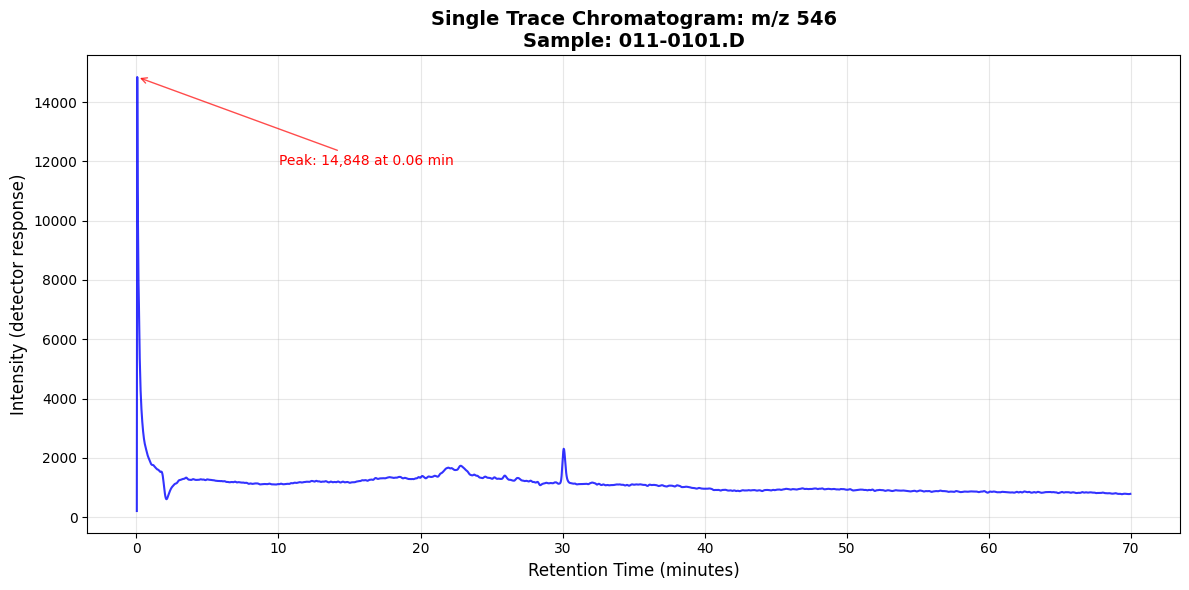

📊 SINGLE TRACE SUMMARY:
   🎯 m/z value: 546
   ⏱️  Time range: 0.032 to 70.0 minutes
   📈 Peak intensity: 14,848 at 0.06 minutes
   📋 Data points: 2,375


In [6]:
if len(successful_data_objects) > 0:

    # Get MSD data from first sample
    sample_data = successful_data_objects[0]
    msd_data = sample_data.get_file("MSD2.MS")

    if msd_data is not None:
        # Select a prominent m/z for demonstration (e.g., m/z 546)
        target_mz = 546

        if target_mz in msd_data.ylabels:
            mz_index = np.where(msd_data.ylabels == target_mz)[0][0]
            chromatogram = msd_data.data[:, mz_index]
            times = msd_data.xlabels

            # Create the plot
            plt.figure(figsize=(12, 6))
            plt.plot(times, chromatogram, 'b-', linewidth=1.5, alpha=0.8)

            # Formatting the plot
            plt.xlabel('Retention Time (minutes)', fontsize=12)
            plt.ylabel('Intensity (detector response)', fontsize=12)
            plt.title(f'Single Trace Chromatogram: m/z {target_mz}\nSample: {data_paths[0].name}',
                     fontsize=14, fontweight='bold')

            # Add grid and styling
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

            # Add annotation about the data
            max_intensity = chromatogram.max()
            max_time = times[np.argmax(chromatogram)]
            plt.annotate(f'Peak: {max_intensity:,.0f} at {max_time:.2f} min',
                        xy=(max_time, max_intensity),
                        xytext=(max_time + 10, max_intensity * 0.8),
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                        fontsize=10, color='red')

            plt.show()

            # Summary
            print(f"📊 SINGLE TRACE SUMMARY:")
            print(f"   🎯 m/z value: {target_mz}")
            print(f"   ⏱️  Time range: {times[0]:.3f} to {times[-1]:.1f} minutes")
            print(f"   📈 Peak intensity: {max_intensity:,.0f} at {max_time:.2f} minutes")
            print(f"   📋 Data points: {len(chromatogram):,}")

        else:
            print(f"⚠️  m/z {target_mz} not found in data")
            print(f"Available m/z values: {msd_data.ylabels}")
    else:
        print("❌ Cannot create plot - MSD2.MS data not available")
else:
    print("⚠️  No data objects available for plotting")

## 7. Plot Multiple Traces (4 traces)

Generate comparison plots showing 4 different traces for comprehensive analysis.

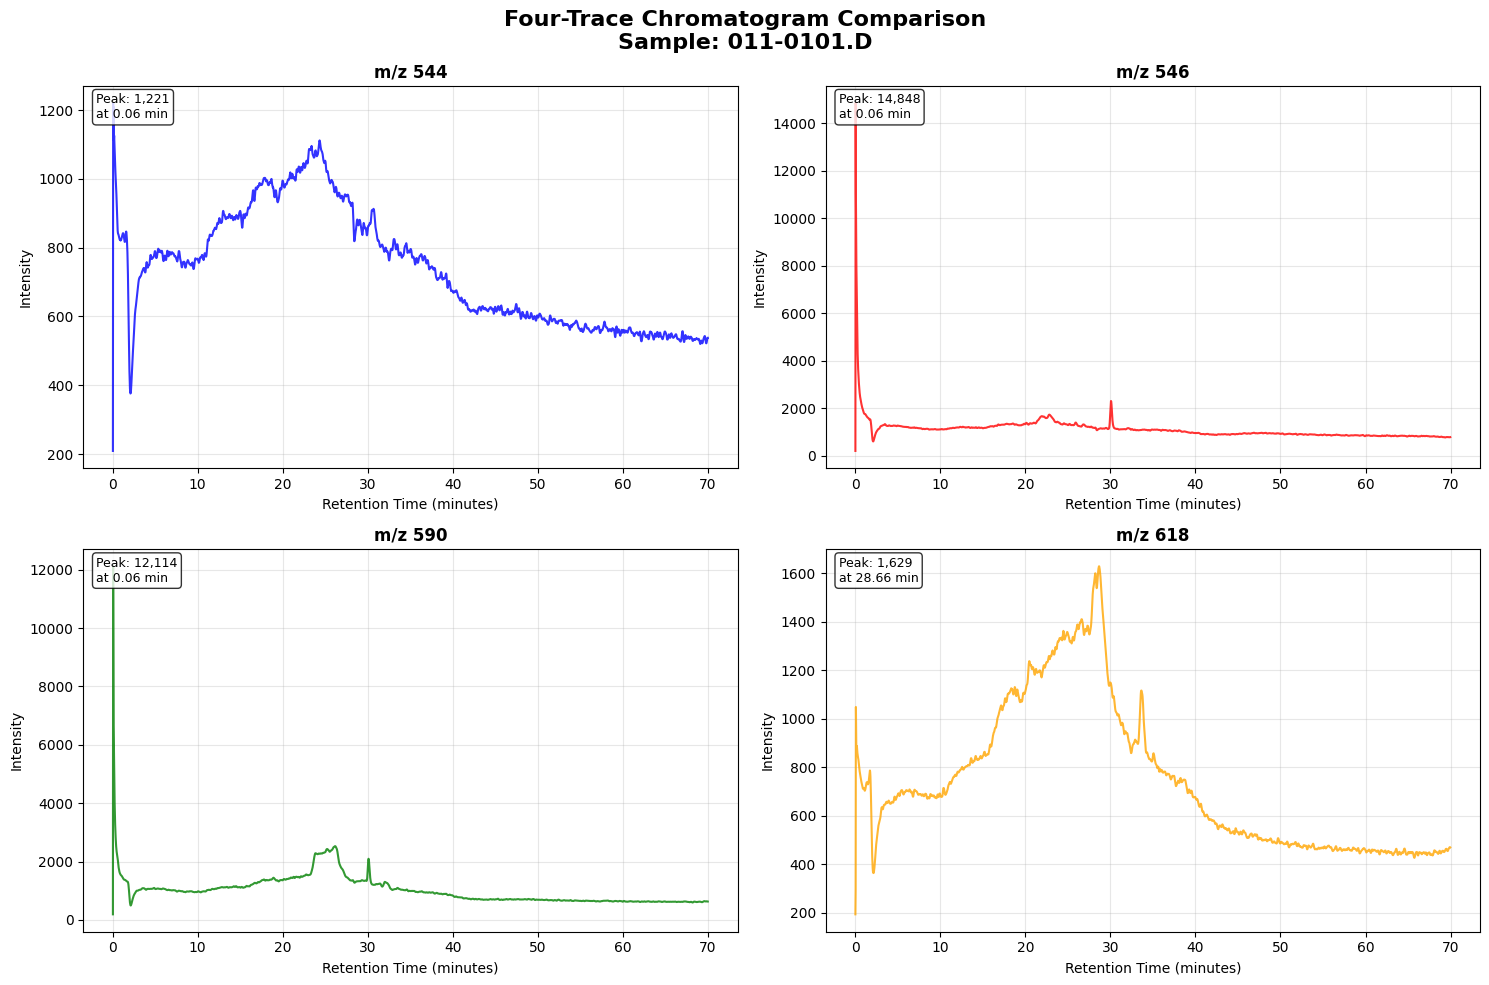

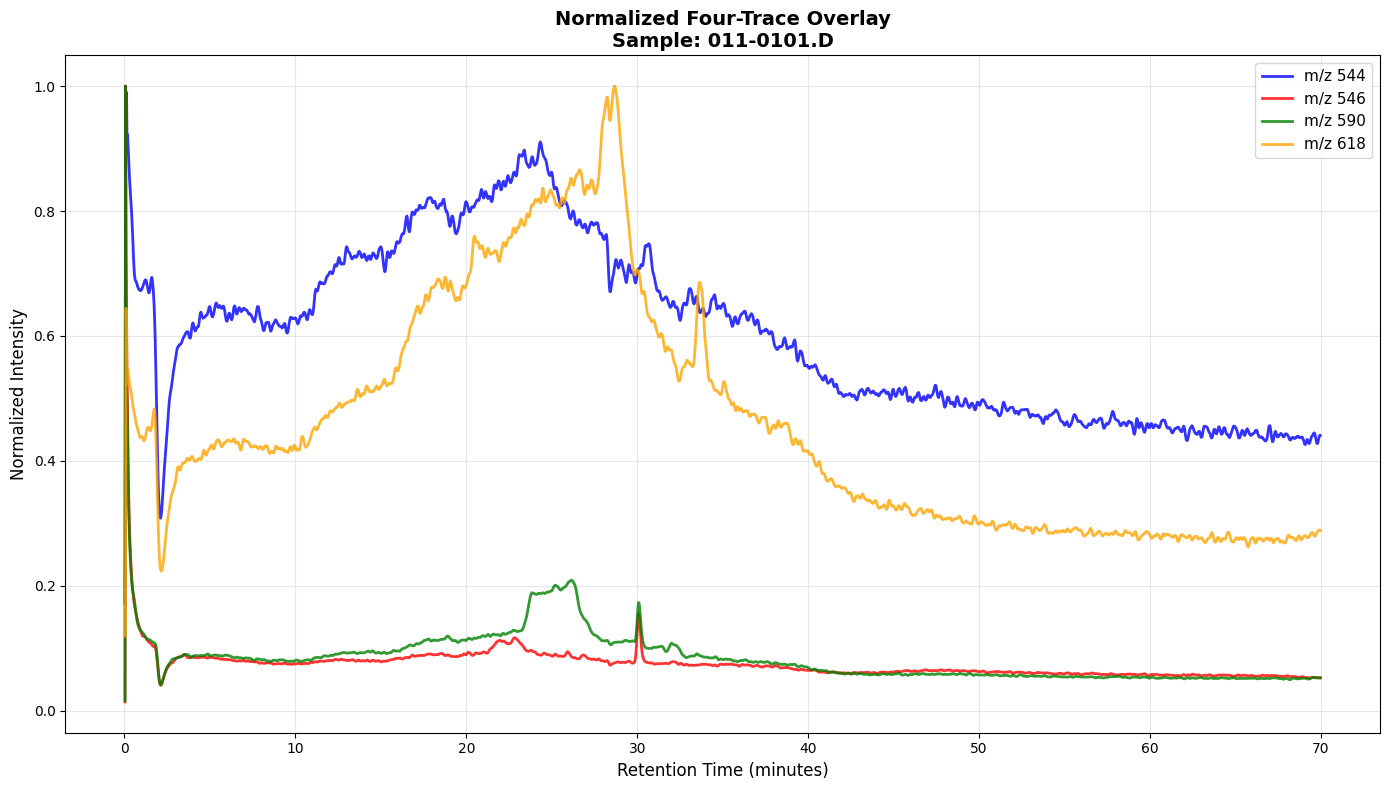

📊 FOUR-TRACE ANALYSIS SUMMARY:
   🎯 Compared m/z values: ['544', '546', '590', '618']
   📋 Sample: 011-0101.D
   ⏱️  Analysis time range: 0.032 to 70.0 minutes

   📈 Peak intensities:
      m/z 544: 1,221 at 0.06 min
      m/z 546: 14,848 at 0.06 min
      m/z 590: 12,114 at 0.06 min
      m/z 618: 1,629 at 28.66 min


In [7]:
# Plot 4 different traces for comprehensive lab analysis
if len(successful_data_objects) > 0:

    # Get MSD data from first sample
    sample_data = successful_data_objects[0]
    msd_data = sample_data.get_file("MSD2.MS")

    if msd_data is not None:
        # Select 4 representative m/z values for comparison
        target_mz_values = [544, 546, 590, 618]  # Adjust based on your data

        # Verify all m/z values exist
        available_mz = []
        for mz in target_mz_values:
            if mz in msd_data.ylabels:
                available_mz.append(mz)

        # If we don't have exactly 4, take the first 4 available
        if len(available_mz) < 4:
            available_mz = msd_data.ylabels[:4].tolist()

        # Create subplot layout
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()  # Flatten for easy indexing

        colors = ['blue', 'red', 'green', 'orange']

        for i, mz in enumerate(available_mz[:4]):
            # Get chromatogram data
            mz_index = np.where(msd_data.ylabels == mz)[0][0]
            chromatogram = msd_data.data[:, mz_index]
            times = msd_data.xlabels

            # Plot on subplot
            axes[i].plot(times, chromatogram, color=colors[i], linewidth=1.5, alpha=0.8)

            # Format subplot
            axes[i].set_xlabel('Retention Time (minutes)', fontsize=10)
            axes[i].set_ylabel('Intensity', fontsize=10)
            axes[i].set_title(f'm/z {mz:.0f}', fontsize=12, fontweight='bold')
            axes[i].grid(True, alpha=0.3)

            # Add peak annotation
            max_intensity = chromatogram.max()
            max_time = times[np.argmax(chromatogram)]
            axes[i].text(0.02, 0.98, f'Peak: {max_intensity:,.0f}\nat {max_time:.2f} min',
                        transform=axes[i].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                        fontsize=9)

        # Overall title
        fig.suptitle(f'Four-Trace Chromatogram Comparison\nSample: {data_paths[0].name}',
                    fontsize=16, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Create overlay plot for direct comparison
        plt.figure(figsize=(14, 8))

        for i, mz in enumerate(available_mz[:4]):
            mz_index = np.where(msd_data.ylabels == mz)[0][0]
            chromatogram = msd_data.data[:, mz_index]
            times = msd_data.xlabels

            # Normalize for better comparison (optional)
            normalized_chromatogram = chromatogram / chromatogram.max()

            plt.plot(times, normalized_chromatogram,
                    color=colors[i], linewidth=2, alpha=0.8,
                    label=f'm/z {mz:.0f}')

        plt.xlabel('Retention Time (minutes)', fontsize=12)
        plt.ylabel('Normalized Intensity', fontsize=12)
        plt.title(f'Normalized Four-Trace Overlay\nSample: {data_paths[0].name}',
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Summary for lab manager
        print(f"📊 FOUR-TRACE ANALYSIS SUMMARY:")
        print(f"   🎯 Compared m/z values: {[f'{mz:.0f}' for mz in available_mz[:4]]}")
        print(f"   📋 Sample: {data_paths[0].name}")
        print(f"   ⏱️  Analysis time range: {msd_data.xlabels[0]:.3f} to {msd_data.xlabels[-1]:.1f} minutes")

        print(f"\n   📈 Peak intensities:")
        for mz in available_mz[:4]:
            mz_index = np.where(msd_data.ylabels == mz)[0][0]
            chromatogram = msd_data.data[:, mz_index]
            max_intensity = chromatogram.max()
            max_time = times[np.argmax(chromatogram)]
            print(f"      m/z {mz:.0f}: {max_intensity:,.0f} at {max_time:.2f} min")

    else:
        print("❌ Cannot create plots - MSD2.MS data not available")
else:
    print("⚠️  No data objects available for plotting")

## 8. Export data to open format

In [9]:
# Create CSV filename based on sample name
sample_name = data_paths[0].stem  # Get filename without .D extension
csv_filename = f"{sample_name}_chromatogram_data.csv"

print(f"📁 Source: {data_paths[0].name}")
print(f"💾 Output: {csv_filename}")
print(f"📊 Data dimensions: {msd_data.data.shape}")

# Use rainbow's built-in CSV export method
msd_data.export_csv(csv_filename)
print(f"✅ Successfully exported using rainbow's export_csv() method")

# Show export details
print(f"📈 CSV contains:")
print(f"   • {len(msd_data.xlabels):,} time points")
print(f"   • {len(msd_data.ylabels)} m/z traces")
print(f"   • {msd_data.data.size:,} total intensity measurements")

# Show file size
csv_path = Path(csv_filename)
if csv_path.exists():
    file_size = csv_path.stat().st_size
    print(f"\n💾 File size: {file_size:,} bytes ({file_size/1024/1024:.2f} MB)")

print(f"\n💡 NOTES:")
print(f"   📊 This CSV file can be opened in Excel, R, MATLAB, etc.")
print(f"   🕒 First column contains retention times in minutes")
print(f"   ⚗️  Subsequent columns contain intensity data for each m/z value")
print(f"   📈 Column headers show the exact m/z values monitored")
print(f"   🔄 Data format is rainbow's standard export format")
print(f"   ⚡ Generated using rainbow's built-in export_csv() method")

📁 Source: 011-0101.D
💾 Output: 011-0101_chromatogram_data.csv
📊 Data dimensions: (2375, 24)
✅ Successfully exported using rainbow's export_csv() method
📈 CSV contains:
   • 2,375 time points
   • 24 m/z traces
   • 57,000 total intensity measurements

💾 File size: 281,843 bytes (0.27 MB)

💡 NOTES:
   📊 This CSV file can be opened in Excel, R, MATLAB, etc.
   🕒 First column contains retention times in minutes
   ⚗️  Subsequent columns contain intensity data for each m/z value
   📈 Column headers show the exact m/z values monitored
   🔄 Data format is rainbow's standard export format
   ⚡ Generated using rainbow's built-in export_csv() method


# Summary

1. **Data Structure**: Each .D folder contains chromatography data with:
   - **Traces (columns)**: Individual m/z values monitored
   - **X-values**: Retention times in minutes  
   - **Intensity values**: Raw detector responses (NOT concentrations)

2. **Processing Workflow**: 
   - Automatic discovery and sorting of .D folders
   - Parallel reading using ThreadPoolExecutor for efficiency
   - Error handling for robust data processing

3. **Analysis Capabilities**:
   - Individual trace inspection and visualization
   - Multi-trace comparison

4. **Data Format**: Compatible with rainbow-api library for:
   - Reading Agilent .D files
   - Exporting to CSV for further analysis